<a href="https://colab.research.google.com/github/ekamperi/colab/blob/master/Transfer_Learning_Dogs_vs_Cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer learning
### Based on a programming assignment of "*Customising your models with TensorFlow 2*" course in Coursera


### Introduction

In this notebook, we will create a neural network model to classify images of cats and dogs, using transfer learning: we will use part of a pre-trained image classifier model (trained on ImageNet) as a feature extractor, and train additional new layers to perform the cats and dogs classification task.


In [1]:
import tensorflow as tf
from tensorflow.keras.models import  Sequential, Model
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D


#### The Dogs vs Cats dataset

In this assignment, we use the [Dogs vs Cats dataset](https://www.kaggle.com/c/dogs-vs-cats/data), which was used for a 2013 Kaggle competition. It consists of 25000 images containing either a cat or a dog. We will only use a subset of 600 images and labels. The dataset is a subset of a much larger dataset of 3 million photos that were originally used as a CAPTCHA (Completely Automated Public Turing test to tell Computers and Humans Apart), referred to as “Asirra” or Animal Species Image Recognition for Restricting Access.

* J. Elson, J. Douceur, J. Howell, and J. Saul. "Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization." Proceedings of 14th ACM Conference on Computer and Communications Security (CCS), October 2007.

Our goal is to train a classifier model using part of a pre-trained image classifier, using the principle of transfer learning.


#### Import the data
The training, validation and testing datasets required for this project can be downloaded from the following links:

images_train: https://drive.google.com/open?id=1r0G39tYaSe7fObGIw6vlxUhv-HkENu4W

images_valid: https://drive.google.com/open?id=1_eMoeMi4KjTbcZpBr1Elz8gNU5SNIyiD

images_test: https://drive.google.com/open?id=1yLGqMixFsqzVznWU8rWrJ9ZHjVDIDTxG

labels_train: https://drive.google.com/open?id=1BEIuwRmS3Md1FgtdW6_45xiH-ysOWjV4

labels_valid: https://drive.google.com/open?id=19SS_jVTPqISO36R6Gia58MSAxAOT4-a8

labels_test: https://drive.google.com/open?id=1KGBMlxxA7b6m2rOIIM3DH2462ZUsP96z

We have stored these files in our Google Drive for use in this Colab notebook.

In [2]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### Load and preprocess the data

In [3]:
# Import the data from your Drive folder

base_path = 'gdrive/MyDrive/Colab Notebooks/dogs_cats_dataset/'

images_train = np.load(base_path + 'images_train.npy') / 255.
images_valid = np.load(base_path + 'images_valid.npy') / 255.
images_test = np.load(base_path + 'images_test.npy') / 255.

labels_train = np.load(base_path + 'labels_train.npy')
labels_valid = np.load(base_path + 'labels_valid.npy')
labels_test = np.load(base_path + 'labels_test.npy')

In [4]:
print("{} training data examples".format(images_train.shape[0]))
print("{} validation data examples".format(images_valid.shape[0]))
print("{} test data examples".format(images_test.shape[0]))

600 training data examples
300 validation data examples
300 test data examples


#### Display sample images and labels from the training set

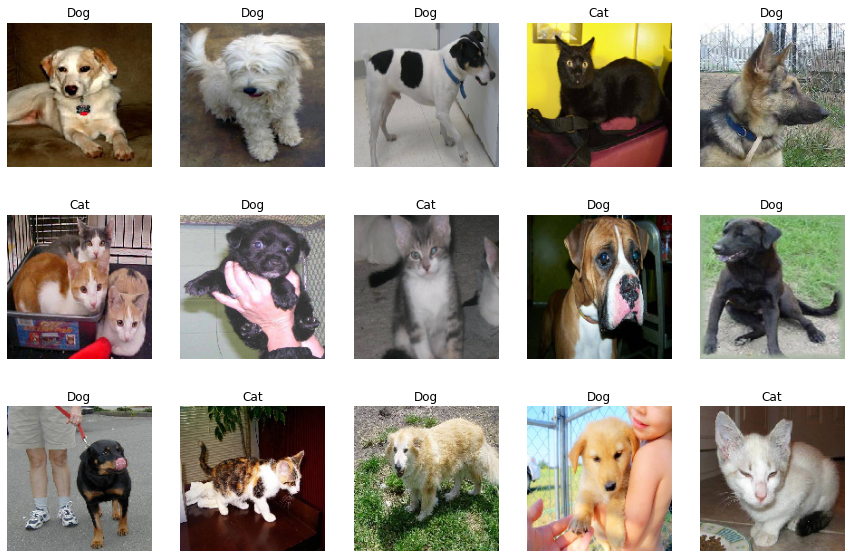

In [5]:
# Display a few images and labels

class_names = np.array(['Dog', 'Cat'])

plt.figure(figsize=(15,10))
inx = np.random.choice(images_train.shape[0], 15, replace=False)
for n, i in enumerate(inx):
    ax = plt.subplot(3,5,n+1)
    plt.imshow(images_train[i])
    plt.title(class_names[labels_train[i]])
    plt.axis('off')

#### Create a benchmark model

We will first train a CNN classifier model as a benchmark model before implementing the transfer learning approach. Using the functional API, build the benchmark model according to the assignments specifications.

In [6]:
def get_benchmark_model(input_shape):
    """
    This function builds and compiles a CNN model according to the above specification,
    using the functional API. The function takes input_shape as an argument, which should be
    used to specify the shape in the Input layer. The function returns the model.
    """
    inputs = Input(shape=input_shape)
    h = Conv2D(32, (3,3), activation='relu', padding='SAME')(inputs)
    h = Conv2D(32, (3,3), activation='relu', padding='SAME')(h)
    h = MaxPooling2D(2,2)(h)
    h = Conv2D(64, (3,3), activation='relu', padding='SAME')(h)
    h = Conv2D(64, (3,3), activation='relu', padding='SAME')(h)
    h = MaxPooling2D(2,2)(h)
    h = Conv2D(128, (3,3), activation='relu', padding='SAME')(h)
    h = Conv2D(128, (3,3), activation='relu', padding='SAME')(h)
    h = MaxPooling2D(2,2)(h)
    h = Flatten()(h)
    h = Dense(128, activation='relu')(h)
    outputs = Dense(1, activation='sigmoid')(h)
    model = Model(inputs=inputs, outputs=outputs)

    opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])
    return model


In [7]:
# Build and compile the benchmark model, and display the model summary
print(images_train[0].shape)
benchmark_model = get_benchmark_model(images_train[0].shape)
benchmark_model.summary()

(160, 160, 3)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 160, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 80, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 80, 80, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 

#### Train the CNN benchmark model

We train the benchmark CNN model using an `EarlyStopping` callback.

In [8]:
# Fit the benchmark model and save its training history

earlystopping = tf.keras.callbacks.EarlyStopping(patience=2)
history_benchmark = benchmark_model.fit(images_train, labels_train, epochs=10, batch_size=32,
                                        validation_data=(images_valid, labels_valid), 
                                        callbacks=[earlystopping])

Epoch 1/10
19/19 [==============================] - 2s 114ms/step - loss: 1.2856 - binary_accuracy: 0.5133 - val_loss: 0.6900 - val_binary_accuracy: 0.5000
Epoch 2/10
19/19 [==============================] - 1s 68ms/step - loss: 0.6954 - binary_accuracy: 0.5333 - val_loss: 0.6943 - val_binary_accuracy: 0.5000
Epoch 3/10
19/19 [==============================] - 1s 68ms/step - loss: 0.6969 - binary_accuracy: 0.5417 - val_loss: 0.6853 - val_binary_accuracy: 0.5700
Epoch 4/10
19/19 [==============================] - 1s 68ms/step - loss: 0.7006 - binary_accuracy: 0.5317 - val_loss: 0.6888 - val_binary_accuracy: 0.5200
Epoch 5/10
19/19 [==============================] - 1s 68ms/step - loss: 0.6942 - binary_accuracy: 0.5133 - val_loss: 0.6891 - val_binary_accuracy: 0.5533


#### Plot the learning curves

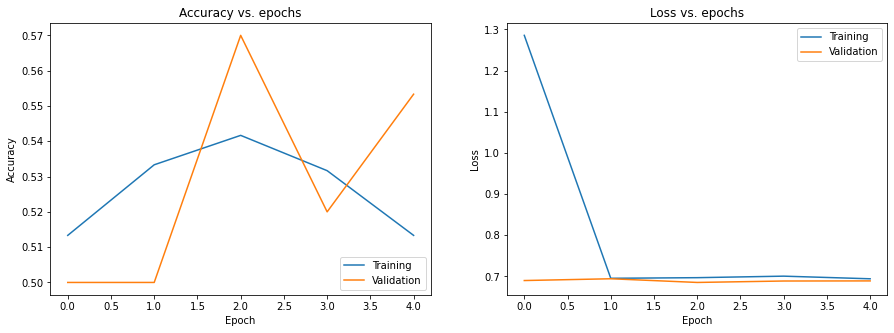

In [9]:
def plot_accuracy(history):
    plt.subplot(121)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')

def plot_loss(history):
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

plt.figure(figsize=(15,5))
plot_accuracy(history_benchmark)
plot_loss(history_benchmark)

#### Evaluate the benchmark model

In [10]:
# Evaluate the benchmark model on the test set

benchmark_test_loss, benchmark_test_acc = benchmark_model.evaluate(images_test, labels_test, verbose=0)
print("Test loss: {}".format(benchmark_test_loss))
print("Test accuracy: {}".format(benchmark_test_acc))

Test loss: 0.689993143081665
Test accuracy: 0.5333333611488342


#### Load the pretrained image classifier model

We will now begin to build our image classifier using transfer learning. We will use the pre-trained MobileNet V2 model, available to download from [Keras Applications](https://keras.io/applications/#mobilenetv2).

In [11]:
from tensorflow.keras.applications import MobileNetV2
base_model= MobileNetV2(input_shape=images_train[0].shape)
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

#### Use the pre-trained model as a feature extractor

We will remove the final layer of the network and replace it with new, untrained classifier layers for our task. We will first create a new model that has the same input tensor as the MobileNetV2 model, and uses the output tensor from the layer with name `global_average_pooling2d` as the model output.

In [12]:
def remove_head(pretrained_model):
    """
    This function takes a pretrained model as an argument.
    It creates and returns a new model, using the input and output tensors
    as specified above.
    """
    new_outputs = pretrained_model.get_layer('global_average_pooling2d').output
    new_model = Model(inputs=pretrained_model.inputs, outputs=new_outputs)
    return new_model
    

In [13]:
# Call the function removing the classification head and display the summary
feature_extractor = remove_head(base_model)
feature_extractor.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________________

We can now construct new final classifier layers for our model. Using the Sequential API, we create a new model according to the following specifications:

* The new model begins with the feature extractor model.
* This is then followed with a new dense layer with 32 units and ReLU activation function.
* This is followed by a dropout layer with a rate of 0.5.
* Finally, this is followed by a Dense layer with a single neuron and a sigmoid activation function.

In total, the network should be composed of the pretrained base model plus 3 layers.

In [14]:
def add_new_classifier_head(feature_extractor_model):
    """
    This function takes the feature extractor model as an argument, and creates
    and returns a new model according to the above specification.
    """
    h = Dense(32, activation='relu')(feature_extractor_model.output)
    h = Dropout(0.5)(h)
    new_outputs = Dense(1, activation='sigmoid')(h)
    new_model = Model(inputs=feature_extractor_model.input, outputs=new_outputs)
    return new_model

In [15]:
# Call the function adding a new classification head and display the summary

new_model = add_new_classifier_head(feature_extractor)
new_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________________

#### Freeze the weights of the pretrained model

We will now need to freeze the weights of the pre-trained feature extractor, so that only the weights of the new layers we have added will change during the training. The optimiser, learning rate, loss and metrics are the same as before (RMSProp, 0.001, binary cross entropy loss, and binary accuracy metric, respectively).

In [16]:
def freeze_pretrained_weights(model):
    """
    This function takes the model specified above as an argument, and freezes the 
    weights of the pre-trained feature extractor. It also compiles the model as
    described above. It returns the model with the specified frozen weights.
    """
    layers = model.layers[:len(model.layers) - 3]
    for layer in layers:
        layer.trainable = False

    opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])
    return model

In [17]:
# Call the function freezing the pretrained weights and display the summary

frozen_new_model = freeze_pretrained_weights(new_model)
frozen_new_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________________

#### Train the model

We are now ready to train the new model on the dogs vs cats data subset. We will use an `EarlyStopping` callback with patience set to 2 epochs, as before.

In [18]:
# Train the model and save its training history

earlystopping = tf.keras.callbacks.EarlyStopping(patience=2)
history_frozen_new_model = frozen_new_model.fit(images_train, labels_train, epochs=10, batch_size=32,
                                                validation_data=(images_valid, labels_valid), 
                                                callbacks=[earlystopping])

Epoch 1/10
19/19 [==============================] - 2s 89ms/step - loss: 0.3822 - binary_accuracy: 0.8450 - val_loss: 0.1509 - val_binary_accuracy: 0.9667
Epoch 2/10
19/19 [==============================] - 1s 33ms/step - loss: 0.1595 - binary_accuracy: 0.9467 - val_loss: 0.1023 - val_binary_accuracy: 0.9600
Epoch 3/10
19/19 [==============================] - 1s 33ms/step - loss: 0.0996 - binary_accuracy: 0.9733 - val_loss: 0.0909 - val_binary_accuracy: 0.9633
Epoch 4/10
19/19 [==============================] - 1s 34ms/step - loss: 0.0691 - binary_accuracy: 0.9750 - val_loss: 0.0900 - val_binary_accuracy: 0.9700
Epoch 5/10
19/19 [==============================] - 1s 33ms/step - loss: 0.0548 - binary_accuracy: 0.9800 - val_loss: 0.0921 - val_binary_accuracy: 0.9667
Epoch 6/10
19/19 [==============================] - 1s 33ms/step - loss: 0.0454 - binary_accuracy: 0.9833 - val_loss: 0.0868 - val_binary_accuracy: 0.9600
Epoch 7/10
19/19 [==============================] - 1s 33ms/step - los

#### Plot the learning curves

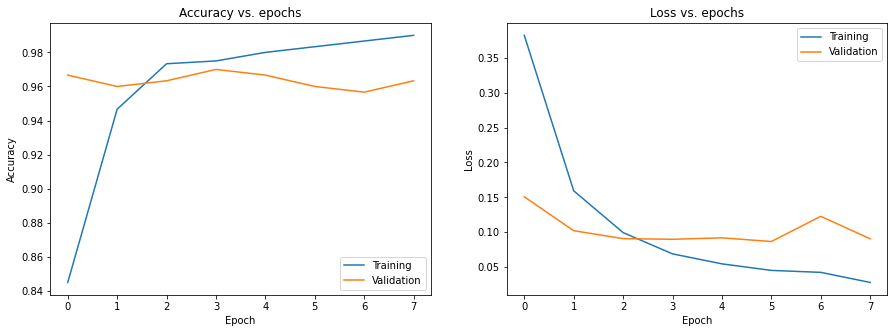

In [19]:
plt.figure(figsize=(15,5))
plot_accuracy(history_frozen_new_model)
plot_loss(history_frozen_new_model)

#### Evaluate the new model

In [20]:
# Evaluate the benchmark model on the test set

new_model_test_loss, new_model_test_acc = frozen_new_model.evaluate(images_test, labels_test, verbose=0)
print("Test loss: {}".format(new_model_test_loss))
print("Test accuracy: {}".format(new_model_test_acc))

Test loss: 0.07155542075634003
Test accuracy: 0.9733333587646484


#### Compare both models

Finally, we will look at the comparison of training, validation and test metrics between the benchmark and transfer learning model.

In [21]:
# Gather the benchmark and new model metrics

benchmark_train_loss = history_benchmark.history['loss'][-1]
benchmark_valid_loss = history_benchmark.history['val_loss'][-1]
benchmark_train_acc = history_benchmark.history['binary_accuracy'][-1]
benchmark_valid_acc = history_benchmark.history['val_binary_accuracy'][-1]

new_model_train_loss = history_frozen_new_model.history['loss'][-1]
new_model_valid_loss = history_frozen_new_model.history['val_loss'][-1]
new_model_train_acc = history_frozen_new_model.history['binary_accuracy'][-1]
new_model_valid_acc = history_frozen_new_model.history['val_binary_accuracy'][-1]

In [22]:
# Compile the metrics into a pandas DataFrame and display the table

comparison_table = pd.DataFrame([['Training loss', benchmark_train_loss, new_model_train_loss],
                                ['Training accuracy', benchmark_train_acc, new_model_train_acc],
                                ['Validation loss', benchmark_valid_loss, new_model_valid_loss],
                                ['Validation accuracy', benchmark_valid_acc, new_model_valid_acc],
                                ['Test loss', benchmark_test_loss, new_model_test_loss],
                                ['Test accuracy', benchmark_test_acc, new_model_test_acc]],
                               columns=['Metric', 'Benchmark CNN', 'Transfer learning CNN'])
comparison_table.index=['']*6
comparison_table

,Metric,Benchmark CNN,Transfer learning CNN
,Training loss,0.694240,0.028137
,Training accuracy,0.513333,0.990000
,Validation loss,0.689084,0.090701
,Validation accuracy,0.553333,0.963333
,Test loss,0.689993,0.071555
,Test accuracy,0.533333,0.973333


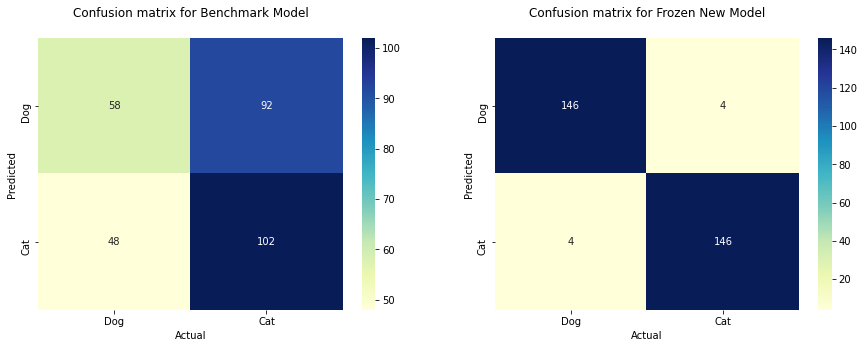

In [23]:
# Plot confusion matrices for benchmark and transfer learning models

plt.figure(figsize=(15, 5))

def conf_matrix_plot(model, title, position):
    preds = model.predict(images_test)
    preds = (preds >= 0.5).astype(np.int32)
    cm = confusion_matrix(labels_test, preds)
    df_cm = pd.DataFrame(cm, index=['Dog', 'Cat'], columns=['Dog', 'Cat'])
    plt.subplot(121 if position == 'left' else 122)
    plt.title(f"Confusion matrix for {title}\n")
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
    plt.ylabel("Predicted")
    plt.xlabel("Actual")

conf_matrix_plot(benchmark_model, 'Benchmark Model', 'left')
conf_matrix_plot(frozen_new_model, 'Frozen New Model', 'right')